## Лабораторная работа №7. 
Рекуррентные нейронные сети для анализа текста
#### Данные: 
Набор данных для предсказания оценок для отзывов, собранных с сайта imdb.com, который состоит из 50,000 отзывов в виде текстовых файлов. Отзывы разделены на положительные (25,000) и отрицательные (25,000). Данные предварительно токенизированы по принципу “мешка слов”, индексы слов можно взять из словаря (imdb.vocab). Обучающая выборка включает в себя 12,500 положительных и 12,500 отрицательных отзывов, контрольная выборка также содержит 12,500 положительных и 12,500 отрицательных отзывов, а также. Данные можно скачать на сайте Kaggle -> https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset
#### Ход выполнения:

###### Задание 1.
Загрузите данные. Преобразуйте текстовые файлы во внутренние структуры данных, которые используют индексы вместо слов.


Скачаем и загрузим данные с сайта Kaggle и отобразим их названия.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)
plt.show()

usecols = ['sentiment','review']
train_data = pd.read_csv(filepath_or_buffer='./input/labeledTrainData.tsv', sep='\t', usecols=usecols)
unlabeled_data = pd.read_csv(filepath_or_buffer="./input/unlabeledTrainData.tsv", error_bad_lines=False, sep='\t')

print('Train reviews:', len(train_data))
print('Test reviews:', len(train_data))

b'Skipping line 43043: expected 2 fields, saw 3\n'


Train reviews: 25000
Test reviews: 25000


Загрузим данные.

In [2]:
import numpy as np

datasets = [train_data, unlabeled_data]

all_reviews = np.array([], dtype=str)
for dataset in datasets:
    all_reviews = np.concatenate((all_reviews, dataset.review), axis=0)
print('Total number of reviews:', len(all_reviews))

Total number of reviews: 74998


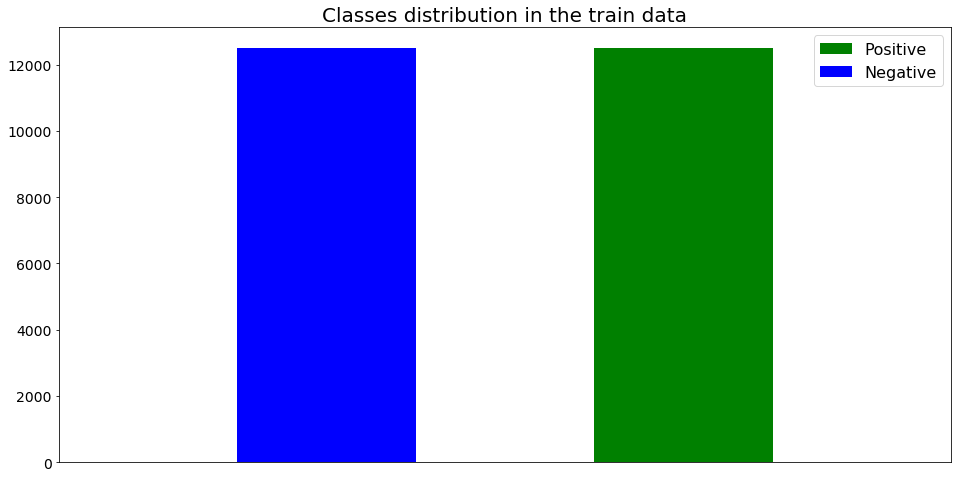

In [3]:
plt.hist(train_data[train_data.sentiment == 1].sentiment, bins=2, color='green', label='Positive')
plt.hist(train_data[train_data.sentiment == 0].sentiment, bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data', fontsize=LARGE_SIZE)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()    

Избавимся от излишних знаков табуляции и приведем текст отзывов к нижнему регистру.

In [4]:
import re
import seaborn as sb
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from bs4 import BeautifulSoup

REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')

def clean_review(raw_review: str) -> str:
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)
    lowercase_letters = letters_only.lower()
    return lowercase_letters

Лемматизируем данные для определения значимых слов, которые необходимо включить в лексикон. 

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english")) 

def lemmatize(tokens: list) -> list:
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words

In [ ]:
counter = 0

def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    review = clean_review(review)
    tokens = word_tokenize(review)
    lemmas = lemmatize(tokens)
    return lemmas

Проведем препроцессинг данных.

In [6]:
all_reviews = np.array(list(map(lambda x: preprocess(x, len(all_reviews)), all_reviews)))
counter = 0

Отобразим графически распределение слов по отзывам.

In [7]:
X_train_data = all_reviews[:train_data.shape[0]]
Y_train_data = train_data.sentiment.values

train_data['review_lenght'] = np.array(list(map(len, X_train_data)))
median = train_data['review_lenght'].median()
mean = train_data['review_lenght'].mean()
mode = train_data['review_lenght'].mode()[0]

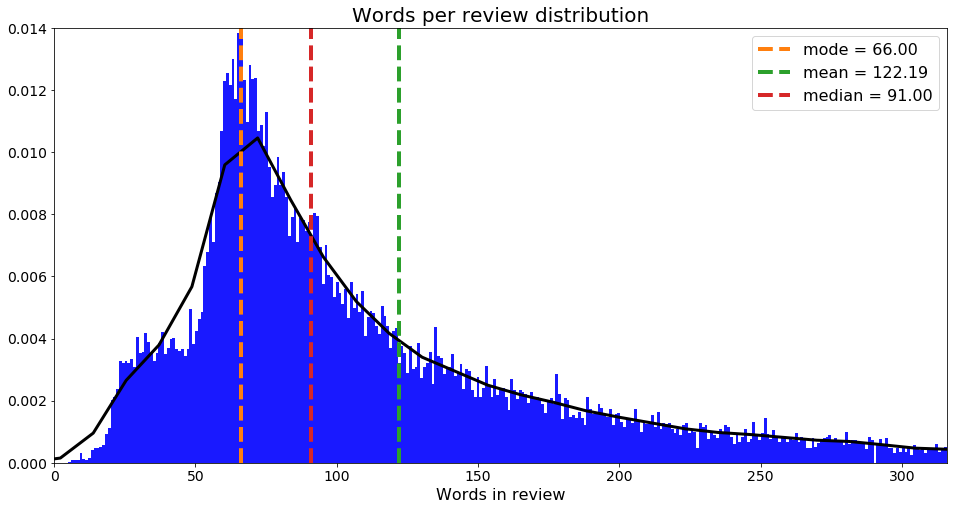

In [8]:
fig, ax = plt.subplots()
sb.distplot(train_data['review_lenght'], bins=train_data['review_lenght'].max(),hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(train_data['review_lenght'], 95))
ax.set_xlabel('Words in review')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()

В среднем отзыв содержит 122 слов.

Приведем слова к биграммам (состоят из 2 слов) и триграммам (состоят из 3 слов).

In [9]:
from gensim.models import Word2Vec, Phrases
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

bigrams = Phrases(sentences=all_reviews)
trigrams = Phrases(sentences=bigrams[all_reviews])
print(bigrams['space station near the solar system'.split()])

embedding_vector_size = 256
trigrams_model = Word2Vec(sentences = trigrams[bigrams[all_reviews]],size = embedding_vector_size, min_count=3, window=5, workers=4)
print("Vocabulary size:", len(trigrams_model.wv.vocab))

print(trigrams_model.wv.most_similar('galaxy'))
print(trigrams_model.wv.doesnt_match(['galaxy', 'starship', 'planet', 'dog']))

['space_station', 'near', 'the', 'solar_system']
Vocabulary size: 77482
[('continent', 0.8522160053253174), ('wormhole', 0.8392743468284607), ('space_station', 0.8220869302749634), ('portal', 0.8091263175010681), ('solar_system', 0.8083268404006958), ('extinct', 0.8065639734268188), ('invader', 0.8053926229476929), ('colony', 0.8041841387748718), ('spacecraft', 0.8021115660667419), ('takeover', 0.8012734651565552)]
dog
Convert sentences to sentences with ngrams... (done)


d:\gwc\frameworks\python373\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


Vectorize sentences... (done)
Transform sentences to sequences... (done)


На примере 'space station near the solar system' можно заметить как биграммы разбивают предложение на пары слов 'space_station', 'near', 'the', 'solar_system'. Также были найдены варинты слов наиболее подходящие по смыслу слову galaxy ('wormhole', 83.93%), ('space_station', 82.21%), ('portal', 80.91%), ('solar_system', 80.83%).

###### Задание 3.
Используйте индексы слов и их различное внутреннее представление (word2vec, glove). Как влияет данное преобразование на качество классификации?


Векторизируем предложения из отзывов и преобразуем во внутренние структуры данных, которые используют индексы вместо слов. Используем Word2vec. Эта модель представляет собой двухслойную нейронную сеть, которая обучается восстанавливать лингвистические контексты слов. Word2vec принимает в качестве входных данных массив текста и создает векторное пространство, каждому уникальному слову присваивается соответствующий вектор в пространстве. Векторы слов расположены в векторном пространстве таким образом, что слова, которые имеют общий контекст, расположены близко друг к другу в пространстве. Данная реализация позволяет собрать слова по принципу их семантической близости и более точно предсказывать результат модели.

In [ ]:
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[X_train_data]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab),maxlen=input_length,padding='post')
print('Transform sentences to sequences... (done)')

In [20]:
print(X_data[0][:20])
print(X_pad[0][:20])

['stuff', 'go', 'moment', 'mj', 'start', 'listen_music', 'watch', 'odd', 'documentary', 'watch', 'wiz', 'watch', 'moonwalker', 'maybe', 'want', 'get', 'certain', 'insight', 'guy', 'think']
[46 47 48 49 50  3 51  1 52 53 54 55 56  3 57 58 22 59  3 60]


Разделим обучающую выборку на тренеровочную и валидационную.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pad,Y_train_data,test_size=0.05,shuffle=True,random_state=42)

###### Задание 2.
Реализуйте и обучите двунаправленную рекуррентную сеть (LSTM или GRU). Какого качества классификации удалось достичь?


Создадим модель нейронной сети, которая будет использовать набор данных для определения является отзыв положительным или отрицательным. Модель состоит из двунаправленного рекуррентного слоя LSTM и нескольких полносвязанных слоев. Функция активации на выходе сигмоидная, так как ожидается один вариант. В качестве функции потерь используем бинарную кроссентропию, в качестве оптимизатора сети выберем Adam.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding

def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(input_dim = embedding_matrix.shape[0],output_dim = embedding_matrix.shape[1], input_length = input_length, weights = [embedding_matrix], trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(embedding_matrix=trigrams_model.wv.vectors, input_length=input_length)

model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 256)          19835392  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 20,246,145
Trainable params: 410,753
Non-trainable params: 19,835,392
______________________________________

Обучим сеть.

In [11]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=100, epochs=20)

Train on 23750 samples, validate on 1250 samples
Epoch 1/20
23750/23750 [==============================] - 997s 42ms/sample - loss: 0.6587 - accuracy: 0.6092 - val_loss: 0.6060 - val_accuracy: 0.6864
Epoch 2/20
23750/23750 [==============================] - 842s 35ms/sample - loss: 0.5695 - accuracy: 0.7141 - val_loss: 0.4978 - val_accuracy: 0.7688
Epoch 3/20
23750/23750 [==============================] - 865s 36ms/sample - loss: 0.5260 - accuracy: 0.7468 - val_loss: 0.4917 - val_accuracy: 0.7632
Epoch 4/20
23750/23750 [==============================] - 878s 37ms/sample - loss: 0.4767 - accuracy: 0.7788 - val_loss: 0.4520 - val_accuracy: 0.7848
Epoch 5/20
23750/23750 [==============================] - 895s 38ms/sample - loss: 0.4359 - accuracy: 0.8013 - val_loss: 0.4909 - val_accuracy: 0.7632
Epoch 6/20
23750/23750 [==============================] - 883s 37ms/sample - loss: 0.4052 - accuracy: 0.8167 - val_loss: 0.4308 - val_accuracy: 0.7928
Epoch 7/20
23750/23750 [=====================

In [ ]:
model.save("model.h5")

In [21]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy = {0:.2f}%\nTest loss = {1:.2f}%'.format(test_accuracy*100.0, test_loss*100.0))

1250/1 - 4s - loss: 0.4117 - accuracy: 0.8000
Test accuracy = 80.00%
Test loss = 82.34%


После обучение точность сети составляет 96.9% на обучающей выборке и 80.0% на тестовой.

Отобразим графически матрицу неточностей (confusion matrix) и графики обучения модели.

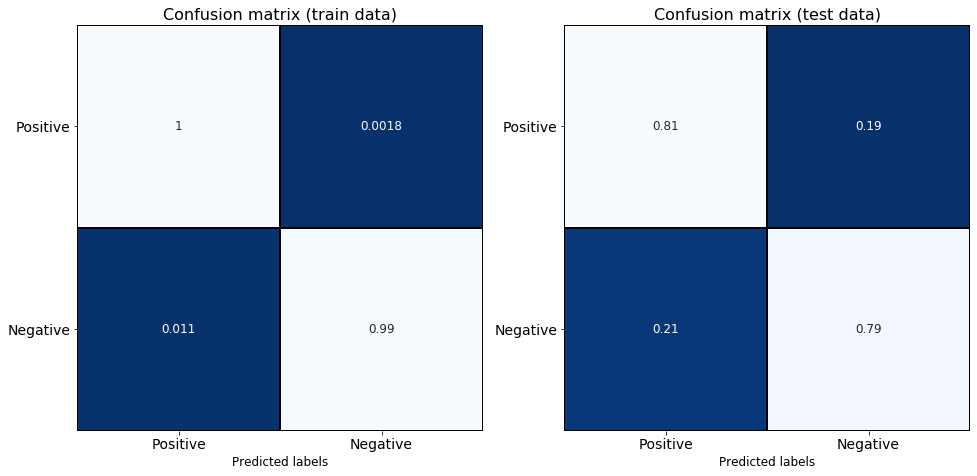

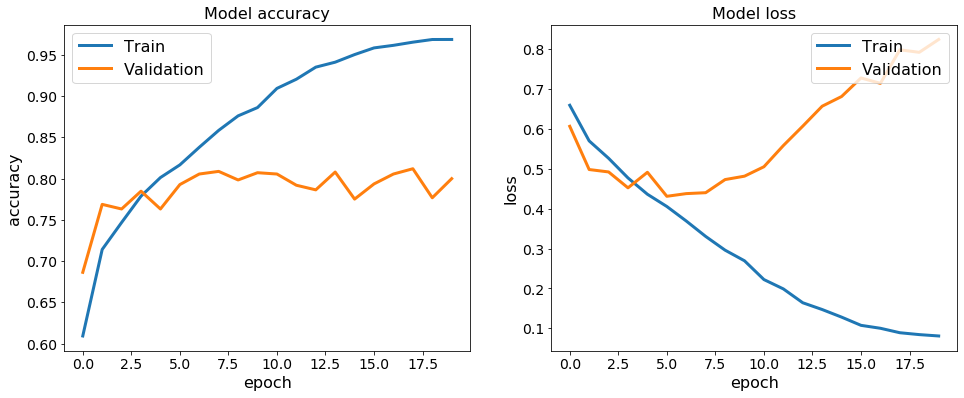

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix

def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None, normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,cmap=plt.cm.Blues_r, cbar=False, linecolor='black',linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

y_train_pred = model.predict_classes(X_train)
y_test_pred = model.predict_classes(X_test)

fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)

plot_confusion_matrix(y_train, y_train_pred, ax=axis1,title='Confusion matrix (train data)',class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,title='Confusion matrix (test data)',class_names=['Positive', 'Negative'])

fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

На тестовой выборке сеть показа результат в 81% для позитивных и 78% для негативных отзывов. Показатели можно увеличить, если обучить сеть на большем размере данных.

###### Задание 4.
Поэкспериментируйте со структурой сети (добавьте больше рекуррентных, полносвязных или сверточных слоев). Как это повлияло на качество классификации?


###### Задание 5.
Используйте предобученную рекуррентную нейронную сеть (например, DeepMoji или что-то подобное).
Какой максимальный результат удалось получить на контрольной выборке?


In [53]:
from keras.models import Model, Sequential
from keras.layers.merge import concatenate
from keras.layers import Input, Bidirectional, Embedding, Dense, Dropout, SpatialDropout1D, LSTM, Activation
from keras.regularizers import L1L2
from attlayer import AttentionWeightedAverage
import numpy as np
from copy import deepcopy
from os.path import exists
import h5py

NB_TOKENS = 50000
NB_EMOJI_CLASSES = 64

def deepmoji_architecture(nb_classes, nb_tokens, maxlen, feature_output=False, embed_dropout_rate=0, final_dropout_rate=0, embed_l2=1E-6, return_attention=False):
    model_input = Input(shape=(maxlen,), dtype='int32')
    embed_reg = L1L2(l2=embed_l2) if embed_l2 != 0 else None
    embed = Embedding(input_dim=nb_tokens, output_dim=256, mask_zero=True, input_length=maxlen, embeddings_regularizer=embed_reg,name='embedding')
    x = embed(model_input)
    x = Activation('tanh')(x)

    embed_drop = SpatialDropout1D(0.2, name='embed_drop')
    x = embed_drop(x)

    lstm_0_output = Bidirectional(LSTM(512, return_sequences=True), name="bi_lstm_0")(x)
    lstm_1_output = Bidirectional(LSTM(512, return_sequences=True), name="bi_lstm_1")(lstm_0_output)
    x = concatenate([lstm_1_output, lstm_0_output, x])

    weights = None
    x = AttentionWeightedAverage(name='attlayer', return_attention=return_attention)(x)
    if not feature_output:
        x = Dropout(0.2)(x)

        if nb_classes > 2:
            outputs = [Dense(nb_classes, activation='softmax', name='softmax')(x)]
        else:
            outputs = [Dense(1, activation='sigmoid', name='softmax')(x)]
    else:
        outputs = [x]

    if return_attention:
        outputs.append(weights)

    return Model(inputs=[model_input], outputs=outputs, name="DeepMoji")

In [ ]:
from __future__ import print_function
import numpy as np
from keras.preprocessing import sequence
from keras.datasets import imdb

nb_tokens = 20000
maxlen = 80
batch_size = 32

print('Loading data...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=nb_tokens)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
model = deepmoji_architecture(nb_classes=2, nb_tokens=nb_tokens, maxlen=maxlen)
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, epochs=15, validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
X_train shape: (25000, 80)
X_test shape: (25000, 80)
Build model...
Model: "DeepMoji"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 80)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 256)      5120000     input_20[0][0]                   
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 80, 256)      0           embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       

d:\gwc\frameworks\python373\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 18100s 724ms/step - loss: 0.4566 - accuracy: 0.7881 - val_loss: 0.3878 - val_accuracy: 0.8337
Epoch 2/15
25000/25000 [==============================] - 19882s 795ms/step - loss: 0.2730 - accuracy: 0.8948 - val_loss: 0.3786 - val_accuracy: 0.8362
Epoch 3/15
25000/25000 [==============================] - 19767s 791ms/step - loss: 0.1773 - accuracy: 0.9376 - val_loss: 0.4525 - val_accuracy: 0.8276
Epoch 4/15
12768/25000 [==============>...............] - ETA: 2:14:00 - loss: 0.1098 - accuracy: 0.9659